<a href="https://colab.research.google.com/github/sandhya-bdb/CNN-model-for-Fruit-Classification-using-ResNet50/blob/main/main_prog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Dataset: Begin by loading the dataset provided.
# Data Augmentation: Apply transformations such as random flip, rotation, color jitter, resizing, etc., to augment the data and enhance model performance.
# Dataset Splitting: Split the dataset into training, validation, and testing sets.
# Visualization: Visualize a few images from the dataset to develop an understanding of the data.

In [2]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [3]:
device = torch.device("cuda" )
device

device(type='cuda')

In [4]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
!find /content/dataset -type d -name ".*" -exec rm -r {} +


find: ‘/content/dataset’: No such file or directory


In [6]:
!ls -a /content/dataset


ls: cannot access '/content/dataset': No such file or directory


In [7]:
import os
os.listdir('/content')




['.config', 'dataset.zip', '.ipynb_checkpoints', 'sample_data']

In [8]:
!ls -a /content


.  ..  .config	dataset.zip  .ipynb_checkpoints  sample_data


In [9]:
!ls -a /content/dataset


ls: cannot access '/content/dataset': No such file or directory


In [10]:
!unzip /content/dataset.zip -d /content/dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/FRUIT-16K/S_Lemon/458.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/935.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/89.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/1000.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/773.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/692.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/854.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/575.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/737.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/656.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/494.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/818.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/100.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/971.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/1.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/890.jpg  
  inflating: /content/d

In [11]:
dataset_path = "/content/dataset/FRUIT-16K"


In [12]:
dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
print(f"Classes found: {dataset.classes}")
print(f"Number of classes: {len(dataset.classes)}")
print(f"Number of samples: {len(dataset)}")


Classes found: ['F_Banana', 'F_Lemon', 'F_Lulo', 'F_Mango', 'F_Orange', 'F_Strawberry', 'F_Tamarillo', 'F_Tomato', 'S_Banana', 'S_Lemon', 'S_Lulo', 'S_Mango', 'S_Orange', 'S_Strawberry', 'S_Tamarillo', 'S_Tomato']
Number of classes: 16
Number of samples: 16000


In [13]:
class_names = dataset.classes
class_names

['F_Banana',
 'F_Lemon',
 'F_Lulo',
 'F_Mango',
 'F_Orange',
 'F_Strawberry',
 'F_Tamarillo',
 'F_Tomato',
 'S_Banana',
 'S_Lemon',
 'S_Lulo',
 'S_Mango',
 'S_Orange',
 'S_Strawberry',
 'S_Tamarillo',
 'S_Tomato']

In [14]:
num_classes = len(dataset.classes)
num_classes

16

In [15]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(12000, 4000)

In [16]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [17]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [18]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [19]:
labels[10]

tensor(13)

In [20]:
images[10].shape

torch.Size([3, 224, 224])

In [21]:
images[10].permute(1,2,0).shape

torch.Size([224, 224, 3])

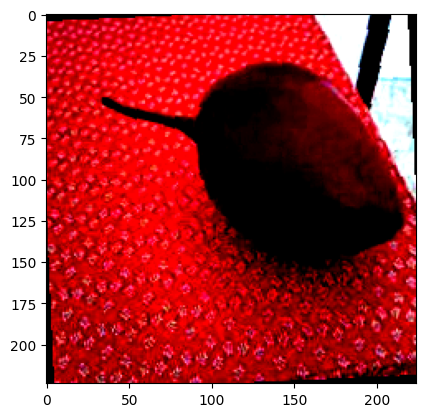

In [22]:
plt.imshow(images[0].permute(1,2,0))
plt.show()

In [23]:
images[30].permute(1,2,0).shape

torch.Size([224, 224, 3])

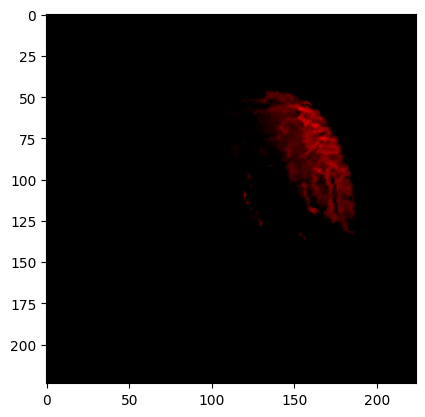

In [24]:
plt.imshow(images[30].permute(1,2,0))
plt.show()

In [25]:
images[15].permute(1,2,0).shape

torch.Size([224, 224, 3])

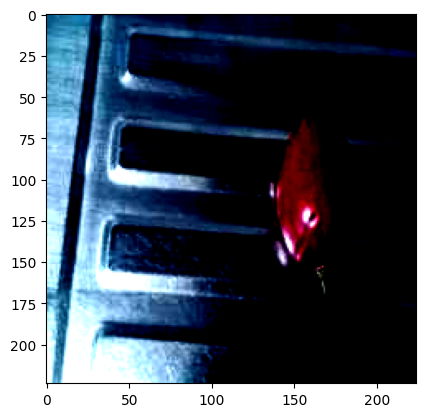

In [26]:
plt.imshow(images[15].permute(1,2,0))
plt.show()

In [27]:
#Tasks:
#Model Training: Begin by building a CNN model. For this task, avoid using transfer learning or regularization techniques initially.
#Validation and Testing: Evaluate the model on both validation and test datasets.
#Optimize Epochs: Experiment with different numbers of training epochs.

In [28]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## model 1: CNN

In [29]:
class FruitClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [30]:
images.size(0)

32

In [31]:
len(train_loader.dataset)

12000

In [32]:
# 1) DataLoaders with single-threaded loading (helps with notebook timeouts)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

def train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=3):
    import time
    start = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            if (batch_num + 1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        model.eval()  # switch to eval mode
        correct, total = 0, 0
        all_labels, all_predictions = [], []

        with torch.no_grad():  # disable gradient computing
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        val_accuracy = 100.0 * correct / total if total > 0 else 0.0
        print(f"*** Validation Accuracy: {val_accuracy:.2f}% ***")


    end = time.time()
    print(f"Execution time: {end - start:.2f} seconds")

    return all_labels, all_predictions


In [33]:
model = FruitClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
all_labels, all_predictions = train_model(
    model, criterion, optimizer,
    train_loader, val_loader, device,
    epochs=3
)


Batch: 10, Epoch: 1, Loss: 2.7983
Batch: 20, Epoch: 1, Loss: 2.7737
Batch: 30, Epoch: 1, Loss: 2.6639
Batch: 40, Epoch: 1, Loss: 2.4370
Batch: 50, Epoch: 1, Loss: 2.0092
Batch: 60, Epoch: 1, Loss: 1.9140
Batch: 70, Epoch: 1, Loss: 1.9075
Batch: 80, Epoch: 1, Loss: 1.7987
Batch: 90, Epoch: 1, Loss: 1.3263
Batch: 100, Epoch: 1, Loss: 1.3785
Batch: 110, Epoch: 1, Loss: 1.3710
Batch: 120, Epoch: 1, Loss: 0.9549
Batch: 130, Epoch: 1, Loss: 0.9805
Batch: 140, Epoch: 1, Loss: 0.9602
Batch: 150, Epoch: 1, Loss: 1.2824
Batch: 160, Epoch: 1, Loss: 0.8388
Batch: 170, Epoch: 1, Loss: 0.9616
Batch: 180, Epoch: 1, Loss: 1.0280
Epoch [1/3], Avg Loss: 1.7077
*** Validation Accuracy: 68.67% ***
Batch: 10, Epoch: 2, Loss: 0.7726
Batch: 20, Epoch: 2, Loss: 0.8619
Batch: 30, Epoch: 2, Loss: 0.6070
Batch: 40, Epoch: 2, Loss: 0.5970
Batch: 50, Epoch: 2, Loss: 0.7196
Batch: 60, Epoch: 2, Loss: 0.5716
Batch: 70, Epoch: 2, Loss: 0.5209
Batch: 80, Epoch: 2, Loss: 0.7267
Batch: 90, Epoch: 2, Loss: 0.5803
Batch: 

In [34]:
#Training and Validation: Plot training and validation accuracy to check for overfitting.
#Regularization Techniques: Apply techniques like batch normalization, weight decay, dropout, and early stopping to improve model performance.
#Hyperparameter Tuning: Experiment with hyperparameters to further increase accuracy.
#Model Saving: Save the best-performing model for future use.

## Model2: CNN with Regularization

In [35]:
class FruitClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [36]:
model = FruitClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
all_labels, all_predictions = train_model(
    model, criterion, optimizer,
    train_loader, val_loader, device,
    epochs=3
)

Batch: 10, Epoch: 1, Loss: 2.7425
Batch: 20, Epoch: 1, Loss: 2.6663
Batch: 30, Epoch: 1, Loss: 2.4427
Batch: 40, Epoch: 1, Loss: 2.3233
Batch: 50, Epoch: 1, Loss: 2.1941
Batch: 60, Epoch: 1, Loss: 1.8062
Batch: 70, Epoch: 1, Loss: 1.4942
Batch: 80, Epoch: 1, Loss: 1.5547
Batch: 90, Epoch: 1, Loss: 1.3325
Batch: 100, Epoch: 1, Loss: 1.3697
Batch: 110, Epoch: 1, Loss: 1.1636
Batch: 120, Epoch: 1, Loss: 0.9247
Batch: 130, Epoch: 1, Loss: 0.8422
Batch: 140, Epoch: 1, Loss: 0.9630
Batch: 150, Epoch: 1, Loss: 1.2344
Batch: 160, Epoch: 1, Loss: 0.7154
Batch: 170, Epoch: 1, Loss: 0.6049
Batch: 180, Epoch: 1, Loss: 0.8190
Epoch [1/3], Avg Loss: 1.5318
*** Validation Accuracy: 73.12% ***
Batch: 10, Epoch: 2, Loss: 0.8787
Batch: 20, Epoch: 2, Loss: 0.6232
Batch: 30, Epoch: 2, Loss: 0.7412
Batch: 40, Epoch: 2, Loss: 0.5129
Batch: 50, Epoch: 2, Loss: 0.5476
Batch: 60, Epoch: 2, Loss: 0.5003
Batch: 70, Epoch: 2, Loss: 0.6377
Batch: 80, Epoch: 2, Loss: 0.8041
Batch: 90, Epoch: 2, Loss: 0.5850
Batch: 

In [37]:
#Apply Transfer Learning: Use a pre-trained model like ResNet50 to train the model.
#Save the Model: Save the trained model to disk for future use.


##model 3: CNN with ResNet50


In [38]:
# Load the pre-trained ResNet model
class FruitClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [39]:
model = FruitClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(
    model, criterion, optimizer,
    train_loader, val_loader, device,
    epochs=3
)





Batch: 10, Epoch: 1, Loss: 2.7801
Batch: 20, Epoch: 1, Loss: 2.4954
Batch: 30, Epoch: 1, Loss: 2.2453
Batch: 40, Epoch: 1, Loss: 1.8508
Batch: 50, Epoch: 1, Loss: 1.5556
Batch: 60, Epoch: 1, Loss: 1.3202
Batch: 70, Epoch: 1, Loss: 1.3841
Batch: 80, Epoch: 1, Loss: 1.2330
Batch: 90, Epoch: 1, Loss: 1.1523
Batch: 100, Epoch: 1, Loss: 1.0328
Batch: 110, Epoch: 1, Loss: 1.0324
Batch: 120, Epoch: 1, Loss: 1.0760
Batch: 130, Epoch: 1, Loss: 1.1077
Batch: 140, Epoch: 1, Loss: 1.1218
Batch: 150, Epoch: 1, Loss: 0.9005
Batch: 160, Epoch: 1, Loss: 0.7383
Batch: 170, Epoch: 1, Loss: 0.7370
Batch: 180, Epoch: 1, Loss: 0.6226
Epoch [1/3], Avg Loss: 1.3810
*** Validation Accuracy: 72.67% ***
Batch: 10, Epoch: 2, Loss: 0.6066
Batch: 20, Epoch: 2, Loss: 0.5673
Batch: 30, Epoch: 2, Loss: 0.7692
Batch: 40, Epoch: 2, Loss: 0.6854
Batch: 50, Epoch: 2, Loss: 0.5826
Batch: 60, Epoch: 2, Loss: 0.4838
Batch: 70, Epoch: 2, Loss: 0.5100
Batch: 80, Epoch: 2, Loss: 0.5992
Batch: 90, Epoch: 2, Loss: 0.3937
Batch: 

## model 4 : CNN with hyperparameter tuning ResNet50


In [40]:
model = FruitClassifierResNet(num_classes=num_classes, dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


all_labels, all_predictions = train_model(
    model, criterion, optimizer,
    train_loader, val_loader, device,
    epochs=3
)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


Batch: 10, Epoch: 1, Loss: 0.6585
Batch: 20, Epoch: 1, Loss: 0.2455
Batch: 30, Epoch: 1, Loss: 0.0979
Batch: 40, Epoch: 1, Loss: 0.0287
Batch: 50, Epoch: 1, Loss: 0.0727
Batch: 60, Epoch: 1, Loss: 0.0346
Batch: 70, Epoch: 1, Loss: 0.0695
Batch: 80, Epoch: 1, Loss: 0.1964
Batch: 90, Epoch: 1, Loss: 0.1409
Batch: 100, Epoch: 1, Loss: 0.0193
Batch: 110, Epoch: 1, Loss: 0.0489
Batch: 120, Epoch: 1, Loss: 0.1410
Batch: 130, Epoch: 1, Loss: 0.0441
Batch: 140, Epoch: 1, Loss: 0.0180
Batch: 150, Epoch: 1, Loss: 0.0218
Batch: 160, Epoch: 1, Loss: 0.0165
Batch: 170, Epoch: 1, Loss: 0.0783
Batch: 180, Epoch: 1, Loss: 0.0149
Epoch [1/3], Avg Loss: 0.1643
*** Validation Accuracy: 98.67% ***
Batch: 10, Epoch: 2, Loss: 0.0263
Batch: 20, Epoch: 2, Loss: 0.0036
Batch: 30, Epoch: 2, Loss: 0.1585
Batch: 40, Epoch: 2, Loss: 0.0272
Batch: 50, Epoch: 2, Loss: 0.0040
Batch: 60, Epoch: 2, Loss: 0.0351
Batch: 70, Epoch: 2, Loss: 0.0070
Batch: 80, Epoch: 2, Loss: 0.0076
Batch: 90, Epoch: 2, Loss: 0.0229
Batch: 

## Model Evaluation using Confusion Matrix and Classification Report


In [41]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       261
           1       1.00      1.00      1.00       270
           2       1.00      1.00      1.00       248
           3       0.98      1.00      0.99       234
           4       1.00      1.00      1.00       236
           5       1.00      1.00      1.00       253
           6       1.00      1.00      1.00       254
           7       1.00      1.00      1.00       241
           8       1.00      1.00      1.00       241
           9       1.00      1.00      1.00       233
          10       1.00      0.99      1.00       257
          11       1.00      1.00      1.00       267
          12       1.00      0.99      1.00       259
          13       1.00      1.00      1.00       227
          14       1.00      1.00      1.00       248
          15       1.00      1.00      1.00       271

    accuracy                           1.00      4000
   macro avg       1.00   

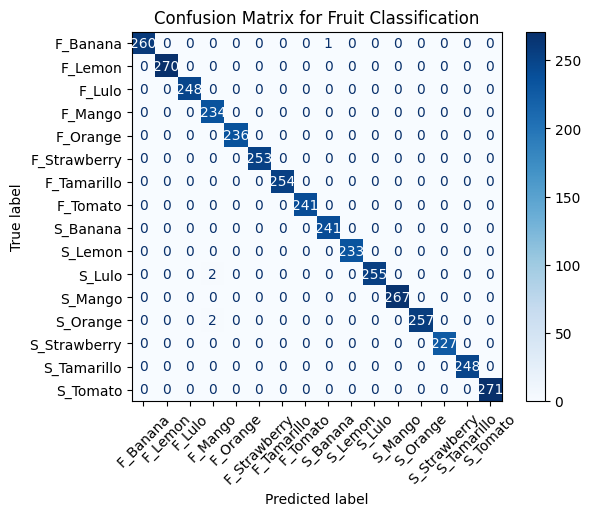

In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Fruit Classification")
plt.show()

## Saving the model

In [43]:
torch.save(model.state_dict(), 'saved_model.pth')